## Paper Experiments

In [88]:
import benchmarks
import algorithm
import data
import importlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
import tabulate
import cloudpickle
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [77]:
def score(predicted, test):
    return np.mean((predicted.reshape(-1)-test.reshape(-1))**2)

# 5.1 Lorenz’s chaotic model

(10, 100)

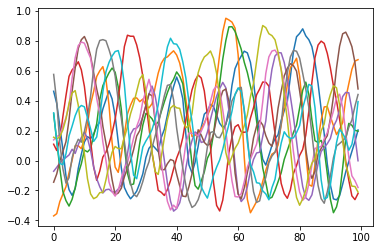

In [78]:
N = 10
T = 100
data_np = np.zeros((N,T))
p = 10
F = 5

# Simulate data
for i in range(N):
    temp, _ = data.simulate_lorenz_96(p, T=T, F=F, delta_t=0.1)
    temp = np.transpose(temp)
    temp = temp / 8
    data_np[i,:] = temp[1,:]
    

# Plot data
plt.plot(np.transpose(data_np))

data = data_np
data.shape # should be #paths x #times

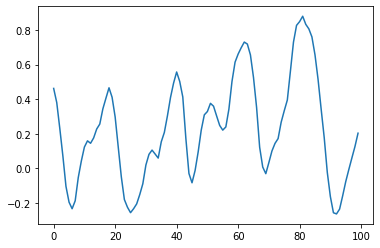

In [79]:
import torch

t = torch.linspace(0., 1., data.shape[1])
xs = torch.tensor(data[1:,:]).float().t().unsqueeze(0)

X = torch.cat([t.unsqueeze(0).unsqueeze(2), xs], dim=2)
Y = torch.tensor(data[0,:]).float().unsqueeze(0).unsqueeze(2) # spain

train_X, train_y = X[:,:70,:], Y[:,:70,:]
test_X, test_y =  X, Y

plt.plot(test_y.squeeze())
plt.show()

t_year = 70

In [80]:
X_train_numpy, Y_train_numpy = np.transpose(data[1:,:t_year]), np.transpose(data[0,:t_year])[:,np.newaxis]
X_test_numpy, Y_test_numpy = np.transpose(data[1:,:]), np.transpose(data[0,:])[:,np.newaxis]

predictions_SC, _ = benchmarks.SC(X_train_numpy , Y_train_numpy, X_test_numpy)

score_SC_lorenz = score(predictions_SC[t_year:], Y_test_numpy[t_year:])

In [81]:
predictions_KMM = benchmarks.KMM(X_train_numpy , Y_train_numpy, X_test_numpy)
score_KMM_lorenz = score(predictions_KMM[t_year:], Y_test_numpy[t_year:])

In [82]:
predictions_elastic_net, _ = benchmarks.elastic_net(X_train_numpy , Y_train_numpy, X_test_numpy)
score_elastic_net_lorenz = score(predictions_elastic_net[t_year:], Y_test_numpy[t_year:])

In [83]:
import torch

train_X, train_y = np.expand_dims(X_train_numpy, axis=0), np.expand_dims(Y_train_numpy, axis=0)
test_X, test_y = np.expand_dims(X_test_numpy, axis=0), np.expand_dims(Y_test_numpy, axis=0)

train_X, train_y = torch.from_numpy(train_X).float(), torch.from_numpy(train_y).float()
test_X, test_y = torch.from_numpy(test_X).float(), torch.from_numpy(test_y).float()

model_path = Path("lorenz_70_model.p")

if not model_path.exists():
    model = algorithm.NeuralCDE(input_channels=train_X.shape[2], hidden_channels=5)
    
    # l1_reg = 0.01
    iterations = 1000

    algorithm.train(model,train_X, train_y, test_X, test_y, iterations)

    with open(model_path, "wb") as f:
        cloudpickle.dump(model, f)
else:
    with open(model_path, "rb") as f:
        model = cloudpickle.load(f)

predictions_NC_SC = algorithm.predict(model,test_X).squeeze()
score_NC_SC_lorenz = score(predictions_NC_SC[t_year:].numpy(), test_y.squeeze()[t_year:].numpy())

### Counterfactual estimation performance

In [84]:
headers = ["Method", "Score"]
results = [
    ["SC", score_SC_lorenz],
    ["KMM", score_KMM_lorenz],
    ["R-SC", score_elastic_net_lorenz],
    ["NC-SC", score_NC_SC_lorenz],
    
]
display(
    HTML(tabulate.tabulate(results, headers=headers, tablefmt="html"))
)


Method,Score
SC,0.104087
KMM,0.0947489
R-SC,0.122184
NC-SC,0.399491


# 5.2 The Eurozone and current account deficits

In [57]:
import data

# import data
X , Y = data.get_emu_data_numpy()
t_year = 19
X_train , Y_train = X[:t_year].copy(), Y[:t_year,np.newaxis].copy()
X_test , Y_test = data.get_emu_data_numpy()

predictions_SC, w_SC = benchmarks.SC(X_train , Y_train, X_test)
score_SC = score(predictions_SC[:t_year], Y_test[:t_year])

In [58]:
predictions_SC, w_SC = benchmarks.SC(X_train , Y_train, X_test)
score_SC = score(predictions_SC[:t_year], Y_test[:t_year])

In [59]:
predictions_KMM = benchmarks.KMM(X_train , Y_train, X_test)
score_KMM = score(predictions_KMM[:t_year], Y_test[:t_year])

In [60]:
predictions_elastic_net, _ = benchmarks.elastic_net(X_train , Y_train, X_test)
score_elastic_net = score(predictions_elastic_net[:t_year], Y_test[:t_year])

In [61]:
X, Y = data.get_emu_data()
train_X, train_y = X[:,:t_year,:], Y[:,:t_year,:]
test_X, test_y = data.get_emu_data()
model_path = Path("eurozone_model.p")

if not model_path.exists():
    model = algorithm.NeuralCDE(input_channels=train_X.shape[2], hidden_channels=5)
    
    # l1_reg = 0.01
    iterations = 1000

    algorithm.train(model,train_X, train_y, test_X, test_y, iterations)

    with open(model_path, "wb") as f:
        cloudpickle.dump(model, f)
else:
    with open(model_path, "rb") as f:
        model = cloudpickle.load(f)

predictions_NC_SC = algorithm.predict(model,test_X).squeeze().numpy()
score_NC_SC = score(predictions_NC_SC[:t_year], Y_test[:t_year])

### Eurozone Counterfactual estimation performance.

In [62]:
headers = ["Method", "Score"]
results = [
    ["SC", score_SC],
    ["KMM", score_KMM],
    ["R-SC", score_elastic_net],
    ["NC-SC", score_NC_SC],
    
]
display(
    HTML(tabulate.tabulate(results, headers=headers, tablefmt="html"))
)


Method,Score
SC,0.00751189
KMM,0.0105038
R-SC,0.0221702
NC-SC,0.000280657


# 5.3 Smoking control in California

In [96]:
# import data in correct format
t_year = 19
X , Y = data.get_smoking_data_numpy()
X_train , Y_train = X[:t_year], Y[:t_year,np.newaxis]
X_test , Y_test = data.get_smoking_data_numpy()

In [97]:
predictions_SC, w_SC = benchmarks.SC(X_train , Y_train, X_test)
score_SC_smoke = score(predictions_SC[:t_year], Y_test[:t_year])

In [98]:
predictions_KMM = benchmarks.KMM(X_train , Y_train, X_test)
score_KMM_smoke = score(predictions_KMM[:t_year], Y_test[:t_year])

In [99]:
predictions_elastic_net, _ = benchmarks.elastic_net(X_train , Y_train, X_test)
score_elastic_net_smoke = score(predictions_elastic_net[:t_year], Y_test[:t_year])

In [100]:
predictions_mc = benchmarks.MC_NNM(X_train , Y_train.reshape(-1, 1), X_test, Y_test.reshape(-1, 1))
score_mc_smoke = score(predictions_mc[:t_year], Y_test[:t_year])

In [101]:
X, Y = data.get_smoking_data()
train_X, train_y = X[:,:t_year,:], Y[:,:t_year,:]
test_X, test_y = data.get_smoking_data()

model_path = Path("smoking_model.p")

if not model_path.exists():
    model = algorithm.NeuralCDE(input_channels=train_X.shape[2], hidden_channels=5)
    
    # l1_reg = 0.01
    iterations = 1000

    algorithm.train(model,train_X, train_y, test_X, test_y, iterations)

    with open(model_path, "wb") as f:
        cloudpickle.dump(model, f)
else:
    with open(model_path, "rb") as f:
        model = cloudpickle.load(f)

predictions_NC_SC = algorithm.predict(model,test_X).squeeze().numpy()
score_NC_SC_smoke = score(predictions_NC_SC[:t_year], Y_test[:t_year])

###  Smoking control Counterfactual estimation performance.

In [102]:
headers = ["Method", "Score"]
results = [
    ["SC", score_SC_smoke],
    ["KMM", score_KMM_smoke],
    ["R-SC", score_elastic_net_smoke],
    ["MC-NNM", score_mc_smoke],
    ["NC-SC", score_NC_SC_smoke],
    
]
display(
    HTML(tabulate.tabulate(results, headers=headers, tablefmt="html"))
)


Method,Score
SC,0.000274366
KMM,0.001482
R-SC,3.11104e-05
MC-NNM,4.52022e-05
NC-SC,0.000138908
